<a href="https://colab.research.google.com/github/denocris/Basics-of-deep-learning-for-cv/blob/main/01_the_convolutional_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>  The Convolutional Layer  </center></h1>

<center>  <img src="https://drive.google.com/uc?export=view&id=18-jE-PasLOM0i4ps2DfVA3zB0lDtdPP7"width="800">  </center> 


### Who am I?

Welcome to my lectures. I am Cristiano De Nobili. For any questions or doubts you can find my contacts here:

* [Linkedin](https://www.linkedin.com/in/cristiano-de-nobili/) and [Twitter](https://twitter.com/denocris) (here I regulary post about AI and Science news)
* My [Personal Website](https://denocris.com) (info about my studies, research and career.)
* My [Instagram](https://www.instagram.com/denocris/?hl=it) (I am a Pilot, so here I mostly post about traveling, flying and adventures)
* My recent TEDx on [AI and Human Creativity](https://youtu.be/8-hrmer9d_E)




---



---




## About This Lecture (Notebook Nr. 1)

In this lecture, we will understand and write from scratch a convolution using basic mathematical and coding tools. Afterward, with the same philosophy, we will build a full convolutional layer. Once in a lifetime, it is fruitful to write algorithms from scratch. This is the only way to deeply understand them.

This notebook is not about Convolutional Neural Networks (CNNs), which are based on convolutions but are more complex algorithms. We will study CNNs later, together with their applications in Computer Vision, a field that deals with how to gain high-level understanding from images or videos.

### Tools used 

In this notebook, we will use basic Python functions together with NumPy library for most of our computation. [NumPy](https://numpy.org/) is a fundamental package for scientific computing with Python. It adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays. Then we will take advantage of common libraries for image visualization and preprocessing, such as [cv2](https://pypi.org/project/opencv-python/) (pythonic OpenCV) and [PIL](https://pillow.readthedocs.io/en/stable/), and for plotting, such as matpltotlib.

### Outline

* digital image as a matrix;
* probabilistic foundation of convolution;
* from fully connected to convolutional layers through; symmetries and invariances;
* build a convolution from scratch;
* multiple input and output channels;
* stride, padding and pooling;
* activation functions and convolutional layer.

## What a digital image is

Before digging into the mathematical details of convolution, we must understand what a digital image is. Convolutions have many applications, from physics to engineering but in these lectures, we will mainly focus on convolutions applied to images.

### Example: size of a smartphone photo

The following picture is a typical smartphone photo. Millions of them are taken every day. Before starting our investigations, it is useful to gain some confidence with a digital photo and its metadata. 

The following pictures are on a Google Drive and we will download them using gdown.

<center>  <img src="https://drive.google.com/uc?id=1c-ONFqayrTB5srWEH6YJ7NFHCNxmvu6O" width="400">  </center> 


In [ ]:
# gdown is used to dowload files from Google Drive.
# The long string is part of the virtual link of the file.
!gdown --id 1c-ONFqayrTB5srWEH6YJ7NFHCNxmvu6O


Downloading...
From: https://drive.google.com/uc?id=1c-ONFqayrTB5srWEH6YJ7NFHCNxmvu6O
To: /content/spritz.JPG
100% 1.28M/1.28M [00:00<00:00, 84.8MB/s]


In [ ]:
import numpy as np
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
img = Image.open('./spritz.JPG')

width, height = img.size
print('width: %d , height: %d' %(img.size[0],img.size[1]))
print("File Size in Bytes: "+str(len(img.fp.read())))

width: 2448 , height: 2448
File Size in Bytes: 1271809


Note that the size in bytes is much smaller than the one you obtain from pixels multiplications (image resolution). The point is that our image is JPG and not in RAW format.

In [ ]:
# convert to numpy array (for future use)
img_np = np.asarray(img)
# the image is colored and has three channels
img_np.shape

(2448, 2448, 3)

In [ ]:
# Functions that help us to display an image, from array-like or PIL image.
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    #plt.axis("off")

We can now inspect all image metadata quite easily

In [ ]:
# If you wish to know more details about the image you can take advantage of exif
exif = {
    ExifTags.TAGS[k]: v
    for k, v in img._getexif().items()
    if k in ExifTags.TAGS
}
exif

{'ApertureValue': (4845, 1918),
 'BrightnessValue': (4480, 583),
 'ColorSpace': 1,
 'ComponentsConfiguration': b'\x01\x02\x03\x00',
 'DateTime': '2017:09:22 18:36:02',
 'DateTimeDigitized': '2017:09:22 18:36:02',
 'DateTimeOriginal': '2017:09:22 18:36:02',
 'ExifImageHeight': 2448,
 'ExifImageWidth': 3264,
 'ExifOffset': 208,
 'ExifVersion': b'0221',
 'ExposureBiasValue': (0, 1),
 'ExposureMode': 0,
 'ExposureProgram': 2,
 'ExposureTime': (1, 335),
 'FNumber': (12, 5),
 'Flash': 16,
 'FlashPixVersion': b'0100',
 'FocalLength': (103, 25),
 'FocalLengthIn35mmFilm': 33,
 'GPSInfo': {1: 'N',
  2: ((45, 1), (38, 1), (5037, 100)),
  3: 'E',
  4: ((13, 1), (45, 1), (4108, 100)),
  6: (18718, 473),
  7: ((0, 1), (0, 1), (0, 100)),
  11: (1, 1),
  29: '1970:01:01'},
 'ISOSpeedRatings': 50,
 'LensMake': 'Apple',
 'LensModel': 'iPhone 5 back camera 4.12mm f/2.4',
 'LensSpecification': ((103, 25), (103, 25), (12, 5), (12, 5)),
 'Make': 'Apple',
 'MakerNote': b"Apple iOS\x00\x00\x01MM\x00\x08\x00\x

### Digital image as a matrix

Gray scale digital images are nothing else than matrices with entries that range from 0 (black) to 255 (white). Color digital images instead are composed by three different matrices, one for each color: red, green, blue (RGB).

<center>  <img src="https://drive.google.com/uc?id=1j_jlZTTtjSoXSoBoAddtwsSpX-d2_Ecw" width="800">  </center> 



## Warm Up Introduction: a probabilistic view.



Let us suppose to have two different dices

* the first one is a standard dice with six faces and the results of its throws are described by a distribution $f(a)$ (we can think about a uniform distribution, as for an ideal dice);
* the second dice has just 4 faces. Let us suppose that its throws are described by some distribution $g(b)$. 

Now, suppose to initially throw the first dice, collect the result, and then throw the second one. Summing their outcomes, which is the total likelihood of obtaining the number $4$?

The probability $P(4)$ can be computed by summing all the possible combinations of throws that end up to sum to $4$. 

$$P(4) = f(1)\cdot g(3) + f(3)\cdot g(1) + f(2) \cdot g(2)$$

If $c$ is the desired sum and $a,b$ the outcome of the first and second throw respectively, we can express the probability as follows

$$ P(c) = \sum_{a+b=c} f(a)\cdot g(b)$$

It turns out that what we have just written above is nothing else than a  convolution! In particular, the convolution of $f$ and $g$, evluated at $c$

$$(f * g)(c) = \sum_{a+b=c} f(a)\cdot g(b) = \sum_{a} f(a)\cdot g(c - a)$$

Starting from the definiton of convolution that stands between the $=$ signs, it is easy to show that convolution is a commutative and associative operation.

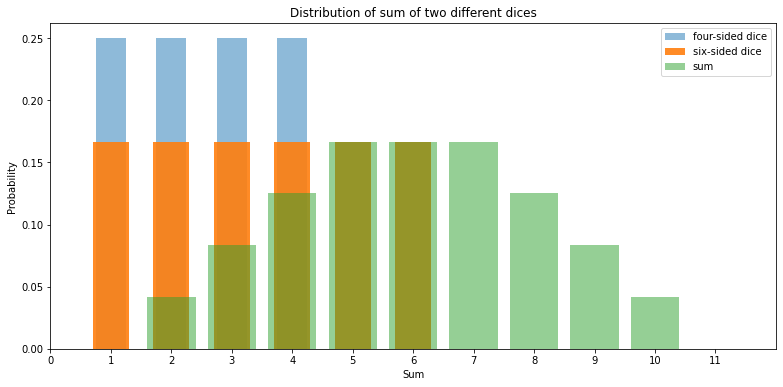

In [ ]:
# Throws of a six-faced dice are described by a uniform distribution.
# Each number, from 1 to 6, has the same probability: 1/6 
sixfaced_dice = np.array([0, 0.16666, 0.166666, 0.16666, 0.166666, 0.166666, 0.166666, 0, 0, 0, 0])
# Throws of a four-faced dice are described by a uniform distribution.
# Each number, from 1 to 4, has the same probability: 1/4 
fourfaced_dice = np.array([0, 0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0])

# Discrete convolution between the two distributions
def Probability(f, g):
  # at most, our sum can be 6+4 = 10
  max_value = 10
  # and... 1+1 = 2
  min_value = 2
  p = np.zeros(max_value + 1)
  for i in range(min_value , max_value + 1):
    for j in range(1, i):
      p[i] += f[i - j] * g[j] # i = 3: f(2)*g(1) + f(1)*g(2)
  return p 

conv = Probability(sixfaced_dice, fourfaced_dice)

# we can check the correctness of the result with built-in python convolution
#conv = np.convolve(sixfaced_dice, fourfaced_dice)

big_grid = range(len(sixfaced_dice))
big_grid_conv = range(len(conv))

# -----------
#    PLOT
# -----------

fig, ax = plt.subplots(figsize=(13,6))

ax.bar(big_grid, fourfaced_dice , 0.5, alpha=0.5, label='four-sided dice')
ax.bar(big_grid, sixfaced_dice , 0.6, alpha=0.9, label='six-sided dice')
ax.bar(big_grid_conv, conv, 0.8, alpha=0.5, label='sum')
ax.set_xticks(range(0, 12))
plt.xlim(0, 12)
ax.set_xlabel('Sum')
ax.set_ylabel('Probability')
ax.set_title(f'Distribution of sum of two different dices')
ax.legend(loc='upper right')
plt.show()

## From Fully Connected Layers to Convolutions: Motivations

A fully connected neural network ( sometimes named dense network) consists of a series of fully connected layers. Mathematically, a fully connected layer is a function $f: R^n \rightarrow R^m$, where $n$ is the number of neurons in layer $L$ while $m$ the number of neurons in layer $L+1$. In this setup, each neuron of a given layer is connected with all neurons of the previous layer, as the figure below shows.

<center>  <img src="https://drive.google.com/uc?id=1lHKirHIrX4VQz7Sb4xFXeOPxQN2XS4Mq" width="700">  </center> 

In general, a fully connected net is composed of an input layer, an output layer and some hidden layers that stand in between. In principle, a lot of common tasks in deep learning could be solved using a simple fully connected net with just one hidden layer. 

In support of the previous claim, the *Universal Approximation Theorem* states that a feed-forward network with a single hidden layer containing a finite number of neurons is sufficient to represent any (regular) function. In practice, the layer may be infeasibly large and may fail to learn and generalize correctly. Therefore, it is common practice to add more layers. However, fully connected neural nets suffer from scalability issues. The number of parameters can easily become enormous. As a consequence, their training requires or a lot of data or a lot of regularization. Let's give a practical example.

Consider a binary classification task, for instance distinguishing car from plane images. We saw that the order of a typical smartphone photo is 1-megapixel. That means the inputs into our network has one million dimensions. 
Now, applying a drastic reduction, we choose the first layer to have $1000$ neurons. However,  the amount of parameters required is still really high, about $10^6 \times 10^3 = 10^9$ just for the first layer. Unless we have copious amounts of data (billions of images of cars and planes), training such a big number of parameters is a mission impossible. One way out could be to reduce the image resolution, let's say to $100 \times 100$. Now the number of parameters for the first dense layer sums to $10^7$. Considering that for simple tasks we need several layers, it's easy to reach impossible numbers of parameters for the whole network. Paradoxically, we run into the issue of exceeding the population of cars and planes in our universe. So, how humans and computers can distinguish cars from planes quite well? How can they do that looking at only a few hundred images?

There is clearly something wrong in the way we are approaching the problem, at least in the case of computer vision tasks. We are now going to find out if a smarter way to approach the problem exists. 

### Symmetries and Invariances 

Our brute force approach based on fully connected neural nets explained above does not take into consideration several aspects of both our images and our final task. Taking inspiration from the way problems are tackled in Physics, we can first understand if our system exhibits some symmetries. If this is the case, symmetries can help to reduce the complexity and the structure of the equations that describe the problem. The following points will help us to better structures our neural network:

* *Translation Invariance:* object detectors should work the same regardless of where in the image an object can be found;

* *Locality:* object detection can be answered by considering only local information. it does not matter what happens in the image at large distances. 

Let us now express mathematically what we just explained in words. We start from a dense layer and impose the above symmetries. A dense layer can formally be expressed by

\\
$$ H[i,j] = \sum_{k, l} W[i,j,k,l] \, X[k,l], $$

\\

where $X[i,j]$ and $H[i,j]$ denote pixel location $(i,j)$ in the input image and hidden representation, respectively. Let us assume that both are 2d-arrays of dimension $height \times weight = h \times w$. For a fixed pixel $(i,j)$ there are $h \times w$ coefficients, i.e. weights. They are expressed by the tensor $W[i,j,k,l]$.

\\
   <center>  <img src="https://drive.google.com/uc?id=19KaJCbygMh8dhxfYRv5rbL4VQBhHoOUk" width="600">  </center> 

\\
  
  We can rewrite the above equation as
  
  \\
  $$ H[i,j] = \sum_{a, b} K[i,j,a,b] \, X[i+a,j+b], $$
  
  \\
  
  just by shifting $k= i+a$ and $l= j +b$. For any given location  $(𝑖,𝑗)$  in the hidden layer $H[𝑖,𝑗]$ , we compute its value by summing over pixels in  $X$, centered around $(𝑖,𝑗)$ and weighted by $K[𝑖,𝑗,𝑎,𝑏]$.
  
Now let us require *Translational Invariance*, that is a shift in the input $X$ should lead to a shift in the activation $H$. This in only possible if $K[i,j,a,b]=K[a,b]$, namely weights are independent of the pixel position $(i,j)$
  
\\
$$ H[i,j] = \sum_{a, b} K[a,b] \, X[i+a,j+b].$$

\\

**This is exactly a (discrete) convolution!** We are effectively weighting pixels  $(𝑖+𝑎,𝑗+𝑏)$  in the vicinity of  (𝑖,𝑗)  with coefficients  $K[𝑎,𝑏]$  to obtain the value  $H[𝑖,𝑗]$. The weighting does not depend on the pixel position $(i,j)$. Note that  $K[𝑎,𝑏]$  needs many fewer coefficients than $K[𝑖,𝑗,𝑎,𝑏]$ since it no longer depends on the location within the image. We have made significant reduction!

Let us now require *Locality*. The intuition is that we should not have to look very far away from $(𝑖,𝑗)$ in order to extract relevant information to assess what is going on at $H[𝑖,𝑗]$. This means that outside some range we can set $K[a,b]=0$

\\
$$ H[i,j] = \sum_{a, b = -\Delta}^{\Delta} K[a,b] \, X[i+a,j+b].$$

\\

When the local region is small, the difference in terms of the number of parameters as compared to a dense network can be dramatic. The price that we pay for this drastic modification is that our features will be translation invariant and that our layer can only take local features into account. We are missing long-range dependencies, but for many computer vision tasks, this is not required.




## Tensor Detour: dimensionality, axis and slice

Understanding what a tensor is and how to deal with its dimensions is essential when working with deep learning or more in general machine learning algorithms.

A tensor is a generalization of vectors and matrices to potentially higher dimensions. A tensor has a shape and in a deep learning setup, all elements have the same data type. Let us list some practical example

In [ ]:
t1 = np.array([0,1])
print(t1.shape, '-> (axis=0, )')

t2 = np.array([[0,1],[2,3],[4,5],[6,7]])
# from left to right, the outer and inner dimension
print(t2.shape, '-> (axis=0, axis=1)')

t3 = np.array([[[0,1,2],[3,4,5]], [[6,7,8],[9,10,11]], [[13,14,15],[16,17,18]], [[19,20,21],[22,23,24]]])
# from left to right, the outer and inner dimension
print(t3.shape, '-> (axis=0, axis=1, axis=2)')


(2,) -> (axis=0, )
(4, 2) -> (axis=0, axis=1)
(4, 2, 3) -> (axis=0, axis=1, axis=2)


We can perform some operations between elements of a tensor and consequently change its dimension. The important aspect to keep in mind is that a tensor has several dimensions, so we need to specify along what specific axis we want to perform our operation.

In [ ]:
t4 = np.array([[0,1],[2,3]])

print('Sum along axis 0: ', np.sum(np.array(t4), axis=0))
print('Sum along axis 1: ', np.sum(np.array(t4), axis=1))
# axis -1 is the inner one
print('Sum along axis -1: ', np.sum(np.array(t4), axis=-1))

Sum along axis 0:  [2 4]
Sum along axis 1:  [1 5]
Sum along axis -1:  [1 5]


We can also select specific slices

In [ ]:
# Select some slices
# Ex: from axis-0 select the first 2 out of 4 elements, from axis-1 the last element, from axis-2 the first two.
t3[0:2, 1:2, 0:2]

array([[[ 3,  4]],

       [[ 9, 10]]])

## Convolution Operation


As we saw above, convolution is a special kind of linear operation. In this lecture we are going to deal with discrete convolution only.

\\
$$ H[i,j] = \sum_{a, b = -\Delta}^{\Delta} K[a,b] \, X[i+a,j+b].$$

\\

The matrix $K$ is called **kernel**, **filter** or sometimes **receptive field**. Its dimensions can be decided depending on the specific problem. Remind that $X[i,j]$ and $H[i,j]$ denote pixel location $(i,j)$ in an input image and hidden representation, respectively.

### Building a Convolution from scratch with Numpy

The challenge here is to build a discrete convolution using only some basic functions from NumPy. In practice, during your daily data science job you will use more general and efficient API to compute convolutions. In this lecture, the aim is to have a deep understanding of the inner mechanism. Let us first define an input Image X (of dimension $ 3 \times 3$) above which we apply a kernel K (of dimension $2 \times 2$).

In [ ]:
# input tensor 3 x 3
# We choose integer numbers to have a better control of what is going on
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=np.float32)
print('X shape: ', X.shape)

# we choose a kernel of size 2 x 2
K = np.array([[0, 1], [2, 3]], dtype=np.float32)
print('K shape: ', K.shape)



X shape:  (3, 3)
K shape:  (2, 2)


Now let us have a look to how in practice a discrete convolution works. $X$ is the input tensor, while $K$ is the *kernel*. The steps are the following 

* overlaying the filter on top of the image at some location; 

* performing element-wise multiplication between the values in the filter and their corresponding values in the image;

* Summing up all the element-wise products;

* Repeat for all locations.



\\

$$\begin{bmatrix} \color{blue} 0 & \color{blue} 1 & 2 \\ \color{blue} 3 & \color{blue} 4 & 5 \\ 6 & 7 & 8 \end{bmatrix} 
\, * \, \begin{bmatrix} \color{blue} 0 & \color{blue} 1 \\ \color{blue} 2 & \color{blue} 3  \end{bmatrix} 
\,=\,  \begin{bmatrix} \color{blue}{19} &25 \\ 37 & 43  \end{bmatrix},  \quad
\begin{bmatrix}  0 & \color{blue} 1 & \color{blue} 2 \\  3 & \color{blue} 4 & \color{blue} 5 \\ 6 & 7 & 8 \end{bmatrix} 
\, * \, \begin{bmatrix} \color{blue} 0 & \color{blue} 1 \\ \color{blue} 2 & \color{blue} 3  \end{bmatrix} 
\,=\,  \begin{bmatrix} 19 & \color{blue}{25} \\ 37 & 43  \end{bmatrix}, \; ...
$$

 \\
 \\
where the element $i,j=0,0$ is obtained from $0\times0 + 1\times1+ 3\times2 + 4\times3 = 19$. Since we are performing a convolution with filter $2 \times 2$ on an image of size $3 \times 3$, we will end up with one matrix of dimension $2 \times 2$ (considering stride 1, but let's overlook this detail now). If you carefully thing about it, there are just 4 unique positions where we can place our filter inside this picture. More in general, the output dimensions are

\\
$$ output_{dim} = \frac{image_{dim} - filter_{dim}}{stride} + 1$$

\\

Since our image shrinks every time we perform convolution, we can do it only a limited number of times, before our image disappears completely. What’s more, if we look at how our kernel moves through the image we see that the impact of the pixels located on the outskirts is much smaller than those in the center of the image. This way we lose some of the information contained in the picture.

Let us write a function that implements the above computation


In [ ]:
def convolution2d(X, K):
    # transform in numpy array
    X = np.array(X)
    K = np.array(K)
    # K dimensions
    h, w = K.shape
    # initialize the output (stride is 1)
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]): #loop on rows
        for j in range(Y.shape[1]): # loop on columns
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
            #print(Y[i, j])
    return Y
  
# NOTE: X * K is multiplication and not matrix-multiplication, which instead is np.dot()
# Uncomment to see the difference
# print(X[0: 0 + 2, 0 : 0 + 2] * K)
# print(np.dot(X[0: 0 + 2, 0 : 0 + 2], K))

Let us now check that we obtain the desired result

In [ ]:
convolution2d(X, K)

array([[19., 25.],
       [37., 43.]])

That is correct! The convolution written above is not the most elegant or efficient in our universe (especially for large images), but it displays the mechanism perfectly. 

### Example: Edge Detection in 2d

It is now useful to see how a kernel can be used to solve a simple but concrete problem, that is detecting the edge of an object in an image by finding the location where pixels change. Again, this example is very simple but thanks to it we will be able to have a deeper understanding of kernels in CNNs. 

In [ ]:
# Our input image will be a matrix with ones and zeros such that
# there is a visible division between them.

X = np.ones((8, 8), dtype=np.float32)
X[2:6,:] = 0
X

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

We now define a filter $K$ (with a height of 2 and width of 1) that, once convolved on the input $X$, will output $0$ if the vertically adjacent elements are the same, otherwise will output $1$ (if the edge is from $1$ to $0$) or $-1$ (if the edge is from $0$ to $1$).


In [ ]:
K = np.array([[1], [-1]])
K.shape

(2, 1)

Now we apply our convolution written above to the image $X$ using filter $K$. Looking at the result we can notice how convolution is able to detect the edges between zeros and ones.

In [ ]:
Y = convolution2d(X, K)
print('Y shape: ', Y.shape)
Y

Y shape:  (7, 8)


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now, if we try to apply $K$ on the transposed input $X.T$, what will be the result?

In [ ]:
X.T

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]], dtype=float32)

In [ ]:
Y = convolution2d(X.T, K)
Y

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

We find a zero matrix! This was expected since the kernel $K$ can only detect vertical edges. In this simple example, we learned that a smart choice of a kernel can find out a desired pattern in the image. Here we have chosen the kernel ab-initio. On the contrary, kernels of a convolutional network are randomly initialized and learned during the training phase.

### Kernels on Image

In the previous section, our kernel was truly simple. One can choose more sophisticated kernels and apply them to an image. Let us see some examples.

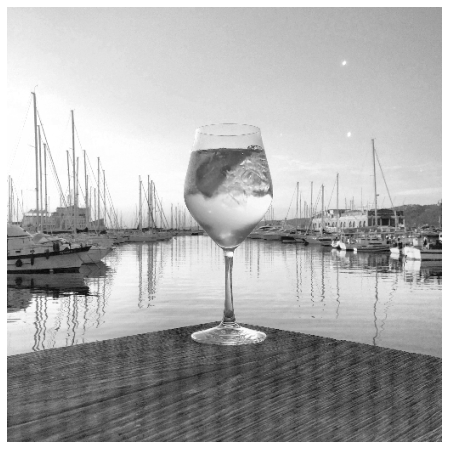

In [ ]:
plt.figure(figsize=(8, 8), constrained_layout=False)

# we resize the image
img_resized_np = cv.resize(img_np , (512,512))
#img_resized_np_norm = np.array(img_resized_np) / 255.0

plt.axis('off')
plt.imshow(img_resized_np[:,:,0], "gray")
plt.show()

In [ ]:
identity = [0, 0, 0,
            0, 1, 0,
            0, 0, 0]

# For edge detection
edge1 = [1, 0, -1,
         0, 0, 0,
         -1, 0, 0]

edge2 = [0,  1, 0,
         1, -4, 1,
         0,  1, 0]

edge3 = [-1, -1, -1,
         -1,  8, -1,
         -1, -1, -1]

# Some effects
sharpen = [ 0, -1,  0,
           -1,  5, -1,
            0, -1,  0]

box_blur = [1, 1, 1,
            1, 1, 1,
            1, 1, 1]
box_blur = [1/9 * i for i in box_blur]

# Gaussian bluring is sometime useful
# ro reduce image noise

gaussian_blur1 = [1, 2, 1,
                  2, 4, 2,
                  1, 2, 1]
gaussian_blur1 = [1/16 * i for i in gaussian_blur1]

gaussian_blur2 = [1,  4,  6,  4, 1,
                  4, 16, 24, 16, 4,
                  6, 24, 36, 24, 6,
                  4, 16, 24, 16, 4,
                  1,  4,  6,  4, 1,]
gaussian_blur2 = [1/256 * i for i in gaussian_blur2]

# Lines detector

horizontal_lines = [-1, -1, -1,
                     2,  2,  2,
                    -1, -1, -1]

vertical_lines = [-1, 2, -1,
                  -1, 2, -1,
                  -1, 2, -1]

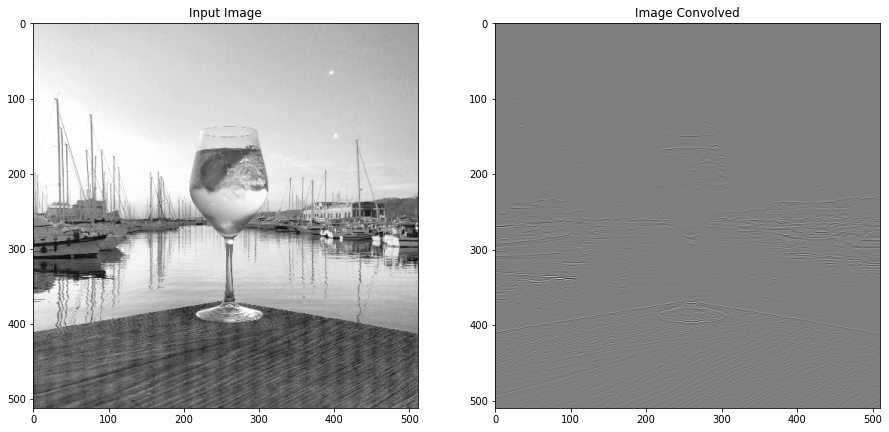

In [ ]:
# Transform the kernel in a numpy array
K = np.array(horizontal_lines)
dim = int(K.shape[0]**0.5)

# Reshape it in matrix-fashion style
K = np.reshape(K, [dim, dim])  # (9,) -> (3,3)

# Let's convolve 
img_conv = convolution2d(img_resized_np[:,:,0], K)

plt.figure(figsize=(40, 40), constrained_layout=False)

plt.subplot(151), plt.imshow(img_resized_np[:,:,0], "gray"), plt.title('Input Image')
plt.subplot(152), plt.imshow(img_conv, "gray"), plt.title('Image Convolved')

plt.show()

## Multiple input and output channels

For simplicity, so far we use convolutions with just a single input and a single output channel. This has allowed us to think of our inputs, convolutional kernels, and outputs each as 2d-arrays. However, many images have colors (RGB, red-green-blue) and convolutional layers may have more than one kernel. In this case, we say that our images or representations have multiple channels. Adding channels into the game, both our inputs and hidden representations become 3d-arrays. For instance, each RGB input image has shape  $3\times h\times w$. We refer to the new axis as the channel dimension.

When the input data contains multiple channels, we need to build a convolution kernel with the same number of channels as the input data, so that it can correctly perform the convolution with the input data.

The following function applies one filter $K$ at an image with 2-channels. The filter $K$ must have two channels as well. The output of this function will be a new image with just one channel, being that we started with just one filter. We are going to see in a while the case of multiple output channels.

   <center>  <img src="https://drive.google.com/uc?id=1kzD5wNtLKft5PceAbUaVTVV_-Pa6HCdQ" width="800">  </center> 

Let us start with the *multiple input channels* case.

### Multiple Input Channels: more than one color

In [ ]:
# Multiple Input Channels

def conv2d_multi_in(X, K):
    X = np.array(X)
    K = np.array(K)
    assert X.shape[0] == K.shape[0]
    # decomment to better understand the details
    #print(list(zip(X, K)))
    #print([convolution2d(x, k) for x, k in zip(X, K)])
    return np.sum([convolution2d(x, k) for x, k in zip(X, K)], axis=0)

As pixels, we choose simple integer numbers to keep control of the computations.

In [ ]:
# X is a 2-channel image
X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])

print("X shape: {}".format(X.shape))

# K must have the same number of channels as the input image.
K = np.array([[[0, 1], [2, 3]], 
              [[1, 2], [3, 4]]])

print("K shape: {}".format(K.shape))

X_conv = conv2d_multi_in(X, K)
print("X_conv shape: {}\n".format(X_conv.shape))
X_conv


X shape: (2, 3, 3)
K shape: (2, 2, 2)
X_conv shape: (2, 2)



array([[ 56.,  72.],
       [104., 120.]])

In [ ]:
# Just to be sure, we check the 1-channel setting

# X is a 1-channel image
X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]]])
print("X shape: {}".format(X.shape))


# K must have the same number of channels as the input image
K = np.array([[[0, 1], [2, 3]]])
print("K shape: {}".format(K.shape))


X_conv = conv2d_multi_in(X, K)
print("X_conv shape: {}".format(X_conv.shape))
X_conv


X shape: (1, 3, 3)
K shape: (1, 2, 2)
X_conv shape: (2, 2)


array([[19., 25.],
       [37., 43.]])

### Multiple Output Channels: more than one filter

In the previous section, we understood that a convolutional filter must have as many channels as the input image. However, in order to extract more features from an image, more than one filter is needed. For instance, we might choose $32$ filters and convolve them on our image. Below it is shown a 2-channel image (image with two colors) which is convolved with two kernels, each of them has 2-channel as we just understood. Each 2-channel kernel acts on the original 2-channel image. For each kernel, the resulting output has 1-channel. Therefore, we end up with many channels as the number of kernels.
   <center>  <img src="https://drive.google.com/uc?id=1wEEMlBN1z5V7c7TYIhKPieTdwSqIP35q" width="600">  </center> 


To keep it simple, in the following example we choose three filters. 


In [ ]:
# X is a 2-channel image
X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
print("X shape: {}".format(X.shape))

K = np.array([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
K = np.stack((K, K + 1, K + 2))
print("K shape: {}".format(K.shape))

X shape: (2, 3, 3)
K shape: (3, 2, 2, 2)


Our multiple input and output channels convolution is build stacking together single corr2d_multi_in(X, k), one for each kernel.

In [ ]:
def conv2d_multi_in_out(X, K):
    X = np.array(X)
    # All of the results are merged
    # together using the stack function
    return np.stack([conv2d_multi_in(X, k) for k in K], 0)

conv2d_multi_in_out(X, K)


array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

The function above is a generalization of the previous ones. The function takes as arguments an image and a filter (they can be many). Then, for each kernel it applies the multi input channel convolution and stacks together the results. We remind here that in these examples we choose ab-initio the kernels to apply. On the contrary, kernel weights of convolutional layers in deep learning are randomly initialized and then learned during the trainig phase. 

Let us now check that our generalization correctly performs in subcases.

In [ ]:
# Just to be sure, we check the 2-channel input setting with just one 2-channel kernel

# X is a 2-channel image 
X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
print("X shape: {}".format(X.shape))

# K is a 2-channel kernel
K = np.array([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
# we must expand it on axis 0 (number of filter axis) to be compatible with conv2d_multi_in_out() function
K = np.expand_dims(K, axis=0)
print("K shape: {}".format(K.shape))


conv2d_multi_in_out(X, K)

X shape: (2, 3, 3)
K shape: (1, 2, 2, 2)


array([[[ 56.,  72.],
        [104., 120.]]])

In [ ]:
# Just to be sure, we check the 1-channel input setting 

# X is a 1-channel image
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
# we must expand it on axis 0 (color axis) to be compatible with conv2d_multi_in_out() function
X = np.expand_dims(X, axis=0)
print("X shape: {}".format(X.shape))

# K is a 2-channel kernel
K = np.array([[0.0, 1.0], [2.0, 3.0]])
# we must expand it on axis 1 (color axis) to be compatible with conv2d_multi_in_out() function
K = np.expand_dims(K, axis=0)
# we must expand it on axis 0 (number of filter axis) to be compatible with conv2d_multi_in_out() function
K = np.expand_dims(K, axis=0)

print("K shape: {}".format(K.shape))

conv2d_multi_in_out(X, K)

X shape: (1, 3, 3)
K shape: (1, 1, 2, 2)


array([[[19., 25.],
        [37., 43.]]])

#### Apply multi-channels convolution to an image

Let us try to apply our convolution to a real image. We choose a kernel that detects veritcal lines

In [ ]:
vertical_lines = [-1, 2, -1,
                  -1, 2, -1,
                  -1, 2, -1]

# reshape the kernel
vertical_lines = np.array(vertical_lines).reshape(3,3)
# let the filter become 3 channel
vertical_lines = np.stack([vertical_lines, vertical_lines, vertical_lines])
# add number-of-kernel axis
vertical_lines = np.expand_dims(vertical_lines, axis=0)
#vertical_lines = np.stack([vertical_lines,vertical_lines,vertical_lines])

print("kernel shape: {}".format(vertical_lines.shape))
#image = np.stack((img_resized_np[:,:,0], img_resized_np[:,:,1], img_resized_np[:,:,2]))
image = img_resized_np.reshape(3, 512, 512)
print("image shape: {}".format(image.shape))

# Check same number of colors
assert vertical_lines.shape[-3] == image.shape[-3]

image_conv = conv2d_multi_in_out(image, vertical_lines)
print("image_conv shape: {}".format(image_conv.shape))

kernel shape: (1, 3, 3, 3)
image shape: (3, 512, 512)
image_conv shape: (1, 510, 510)


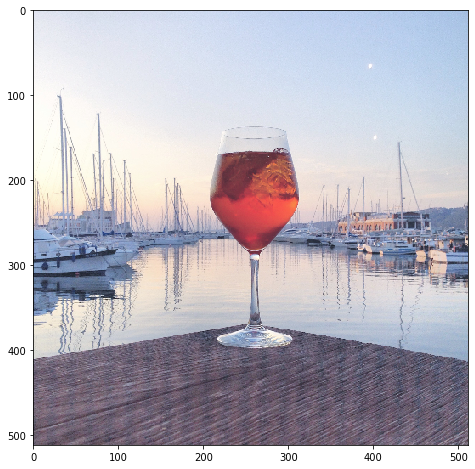

In [ ]:
image = image.reshape(512, 512, 3)
image_conv = np.uint8(image_conv.reshape(510, 510))
#image_conv = np.uint8(image_conv.reshape(510, 510, 3))
plt.figure(figsize=(8, 8), constrained_layout=False)
plot_color_image(image)

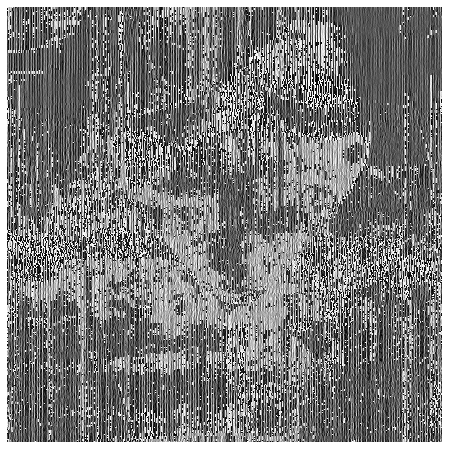

In [ ]:
plt.figure(figsize=(8, 8), constrained_layout=False)
plot_image(image_conv)
#plot_color_image(image_conv)

Next cell is just a check of the goodness of our results with the built-in PyTorch Conv2d function.

In [ ]:
import torch
import torch.nn as nn 

m = nn.Conv2d(in_channels = 3, out_channels = 1, kernel_size = 3, stride=1, bias = False)

def weight_init(m):
    if isinstance(m, nn.Conv2d):
        m.weight = nn.Parameter(torch.from_numpy(vertical_lines).float())

m.apply(weight_init)

image_pt = torch.tensor(image.astype(np.float32))
image_pt = image_pt.view(1, 3, 512, 512)

# Let us convolve the image
image_conv_pt = m(image_pt)
image_conv_pt = image_conv_pt.detach().numpy().reshape(510, 510, 1)

# Their difference must be zero
image_conv_pt = np.uint8(image_conv_pt)
diff = image_conv_pt.reshape(510, 510, 1) - image_conv.reshape(510, 510, 1)

assert all(v <= 1e-5 for v in diff.flatten())

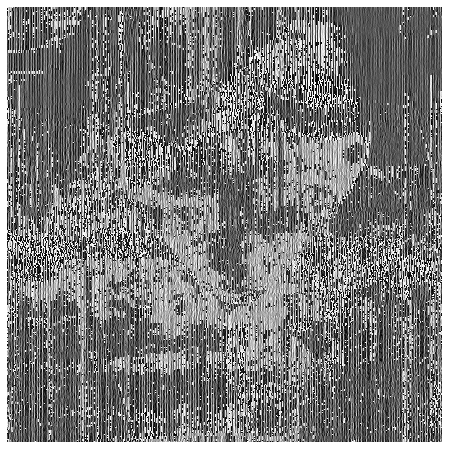

In [ ]:
plt.figure(figsize=(8, 8), constrained_layout=False)
plot_image(image_conv_pt.reshape(510, 510))

Let us profile our convolution versus the PyTorch built-in function. We will understand why it is convinient to use the latter!

In [ ]:
image = image.reshape(3, 512, 512)
%time conv2d_multi_in_out(image, vertical_lines)

CPU times: user 4.18 s, sys: 1.99 ms, total: 4.18 s
Wall time: 4.19 s


array([[[ -11.,  -40.,  -88., ...,   54.,  -85.,   30.],
        [  14.,  -40.,  -82., ...,   68.,  -95.,   42.],
        [   0.,  -32.,  -79., ...,   77., -105.,   50.],
        ...,
        [ -16.,   -9., -112., ...,   37.,  -63.,  121.],
        [  41.,  -36., -117., ...,   19.,  -43.,   94.],
        [  49.,  -46., -115., ...,   60., -139.,  138.]]])

In [ ]:
%time m(image_pt)

CPU times: user 12.9 ms, sys: 1 ms, total: 13.9 ms
Wall time: 16.3 ms


tensor([[[[ -11.,  -40.,  -88.,  ...,   54.,  -85.,   30.],
          [  14.,  -40.,  -82.,  ...,   68.,  -95.,   42.],
          [   0.,  -32.,  -79.,  ...,   77., -105.,   50.],
          ...,
          [ -16.,   -9., -112.,  ...,   37.,  -63.,  121.],
          [  41.,  -36., -117.,  ...,   19.,  -43.,   94.],
          [  49.,  -46., -115.,  ...,   60., -139.,  138.]]]],
       grad_fn=<MkldnnConvolutionBackward>)

## Stride and Padding

Now it is time to discuss two important concepts: *stride* and *padding*. We are not going to implement them from scratch since they are a bit cumbersome. Here we will just define them. Afterwords, when we will introduce and use TensorFlow layers (where padding and slice are implemented) we will discuss and remind them.

### Stride

So far, we have used strides of $1$, both for height and width. That means that our filter slides one pixel at a time over the input. However, it is sometimes useful to move our window more than one pixel at a time, skipping the intermediate locations. The reason to set up stride greater than one can be either for computational efficiency or because we wish to downsample. Considering stride, the output dimension can be computed as follow


\\
$$ output_{dim} = \frac{image_{dim} - filter_{dim}}{stride} + 1$$

\\

<center>  <img src="https://drive.google.com/uc?id=1Prh65s4t7H1pO1u6X2UgzaFfdA9Z4wnh" width="700">  </center> 



### Padding

When applying convolutional layers, one drawback is that we lose pixels on the perimeter of our image. Since we typically use small kernels, for any given convolution, we might only lose a few pixels, but this can add up as we apply many successive convolutional layers. One straightforward solution to this problem is to add extra pixels (typically we set them to 0) around the boundary of our input image, thus increasing the effective size of the image. 

\\

<center>  <img src="https://drive.google.com/uc?id=1HJ09w93knWCIBZiIixO4EizRs1I_sBUu" width="700">  </center>

When padding is added (in TensorFlow, it is used the flag "SAME") the output size of a squared image can be computed using

\\
$$ output_{dim} = \frac{image_{dim}-filter_{dim} + padding + 1}{stride} $$

\\

Considering the figure above, the padding value is 2 (one on the left, one on the right) and the image size is intended before being padded. So, $3-2+2+1=4$. 

In many cases, we will want to set  $padding=filter_{dim}−1$ to give the input and output the same height and width. 


When padding is not added we usually refer to "VALID" padding scheme.

## Pooling Layer

We introduce pooling layers, which serve the following purposes:

* mitigate the sensitivity of convolutional layers:
* spatially downsampling the representations.

Much of the information contained in a convolutional layer output is redundant.
Neighboring pixels in images tend to have similar values, so convolutional layers will typically also produce similar values for neighboring pixels in outputs. Similarly to convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window. Typically they compute either the maximum or the average value of the elements in the pooling window.

Unlike convolutional layer, the pooling layer contains no parameters to train (no filter to be learned). However, they are deterministic and constrained only by hyperparameters such as the window size that specifies the height and width of the window you would compute a max or average over. 


Let's give an example and apply *max pooling* to our $3 \times 3$ image.

$$\begin{bmatrix} \color{blue} 0 & \color{blue} 1 & 2 \\ \color{blue} 3 & \color{blue} 4 & 5 \\ 6 & 7 & 8 \end{bmatrix} 
\, * \, \text{[2 x 2 Max Pooling]}  
\,=\,  \begin{bmatrix} \color{blue}{4} &25 \\ 37 & 43  \end{bmatrix}, \quad 
\begin{bmatrix}  0 & \color{blue} 1 & \color{blue} 2 \\  3 & \color{blue} 4 & \color{blue} 5 \\ 6 & 7 & 8 \end{bmatrix} 
\, * \, \text{[2 x 2 Max Pooling]}  
\,=\,  \begin{bmatrix} 4 & \color{blue}{5} \\ 7 & 8  \end{bmatrix}, \quad ... $$

Other common pooling layers are *average pooling* and *min pooling*. Max pooling selects the brighter pixels from the image. It is useful when the background of the image is dark and we are interested in only the lighter pixels of the image. For example: in MNIST dataset, the digits are represented in white color and the background is black. So, max pooling is used. Similarly, min pooling is used in the other way round. The average pooling method smooths out the image and hence the sharp features may not be identified when this pooling method is used.

We will apply these pooling layers later in the lectures.

## Convolutional Layer: Convolution + Non-Linear Activation Function (+ bias)

Convolution is a linear operation. We already said it, but it is a good exercise (for you) to prove it mathematically. Therefore, to solve non-linear problems we need to add in our process some non-linearities. This can be done adding after the convolution a non-linear activation function. In general, activation functions are an extremely important feature of artificial neural networks. They basically decide whether a neuron should be activated or not. Whether the information that the neuron is receiving is relevant or should it be ignored. Plenty of things could be said about which activation function is better for a given layer or task. For the moment, we just underline that a good activation function should be a smooth function (differentiable function). That means, we can find the slope of the curve at any given point. This is important for the backpropagation algorithm to work.

Below, are common activation functions

In [ ]:
def tanh(x):
    return np.tanh(x)

# Logistic Activation Function
def logistic(x):
    return 1/(1 + np.exp(-1*x))

# relu Activation
def relu(x):
  return (np.abs(x) + x)*0.5 

We are now going to build a convolutional layer, using our convolution definition from above.

In [ ]:
def conv2Dlayer(x, k, bias=0, act=relu):
    #x = tf.nn.conv2d(x, K, strides=[1,1,1,1], padding='VALID')
    x_conv = convolution2d(x, k)
    # one bias for each neuron
    w, h = x_conv.shape[0], x_conv.shape[1]
    b = np.array([bias]*w*h) 
    # reshape b according to x
    b = np.reshape(b, [w,h])
    return act(x_conv+b)
  

# X is a 1-channel image
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])

# K is a 1-channel filter
K = np.array([[0, 1], [2, 3]])

conv2Dlayer(X, K, act=logistic)

## Exercise: Temporal or 1d Convolution

Build a one dimensional convolution which is able to detect gaps in a vector. For instance, given as input 
$$[0,0,0,1,1,1,2,2,2]$$
it returns
$$[0,0,1,0,0,1,0,0].$$

In [ ]:
X = np.array([0,0,0,1,1,1,2,2,2])
K = np.array([-1, 1])

def convolution1d(X, K):
    l = len(K)
    # initialize the output
    Y = np.zeros((X.shape[0] - l + 1))
    for i in range(Y.shape[0]):
            Y[i] = (X[i: i + l] * K).sum()
    return Y

In [ ]:
convolution1d(X, K)

array([0., 0., 1., 0., 0., 1., 0., 0.])